
# Data Analysis  
# Classification 1

In this lecture, we'll discuss:
* the overview of classification and how we can evaluate this task
* logistic regression (LR) 
* LR vs. k-NN 
* linearity vs. non-linearity
* generalizability and cross validation 

Recommended Reading: 
* G. James, D. Witten, T. Hastie, and R. Tibshirani, An Introduction to Statistical Learning, Ch. 4 [digital version available here](https://www.statlearning.com/)
* See also resources on the Syllabus


In [1]:
# imports and setup

import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm

import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('fivethirtyeight')
sns.set_context("talk")
sns.set_theme()
#sns.set()

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# 1. Classification 

Recall that in **regression**, we try to predict a real-valued (quantitative) variable. Examples:
1. Predict house prices based on attributes
+ Predict credit score rating based on income, balance, gender, education, etc...

In **classification**, we try to predict a categorical (qualitative) variable. Examples:
1. Predict whether a bank should issue a person a credit card (yes/no)
+ Predict a hospital patient's diagnosis (stroke, heart attack,...) based on symptoms. 

**Data:** $n$ samples $(x_1,y_1), (x_2,y_2),\ldots,(x_n,y_n)$, where $x_i$ are attributes or features and $y_i$ are categorical variables that you want to predict. 

**Goal:** Develop a rule for predicting the categorical variable $y$ based on the features $x$. 

**Example 1:** Can the number of hours a student studies predict whether they will pass the exam?

**Example 2:** If I have digit pictures (in jpg format), can I identify which digit is ($0,1,2,...,9$) based on the value of the pixels?

In the next couple of lectures, we'll cover several classification methods:
* logistic regression (and comparison with k-NN)
+ tree-based models (simple DTs, bagging (random forests) and boosting (XGBoost))

Also, there is another lecture (last one) where we discuss interpretable models.

## 1.1 Obtaining the Data, Preparations, Observations

For this lecture, we will use the Wisconsin Breast Cancer Dataset which we can obtain from [scikit learn](http://scikit-learn.org/stable/datasets/index.html#breast-cancer-wisconsin-diagnostic-database). 

This dataset consists of measurements from tumor biopsies for 569 patients as well as whether the tumor was malignant or benign.

In [2]:
import sklearn.datasets
data_dict = sklearn.datasets.load_breast_cancer()
data = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### The Prediction Task

The prediction task for this data is to predict whether a tumor is benign or malignant (a binary decision) given characteristics of that tumor. As a classic machine learning dataset, the prediction task is captured by the column named `target`.  To put the data back in it's original context we will create a new column called `malignant` which will be 1 if the tumor is malignant and 0 if it is benign (reversing the definition of target).  

In [3]:
# Target data_dict['target'] = 0 is malignant 1 is benign
data['malignant'] = (data_dict['target'] == 0).astype(int)

### Selecting Features

What features might be a good indication of whether a tumor is benign or malignant? 

In [4]:
data.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'malignant'],
      dtype='object')

In [5]:
data[['mean radius', 'malignant']]

,mean radius,malignant
0,17.99,1
1,20.57,1
2,19.69,1
3,11.42,1
4,20.29,1
...,...,...
564,21.56,1
565,20.13,1
566,16.60,1
567,20.60,1


Perhaps a good starting point is the size of the tumor.  Larger tumors are probably more likely to be malignant.  In the following, we plot whether the tumor was malignant (1 or 0) against the `"mean radius"`.

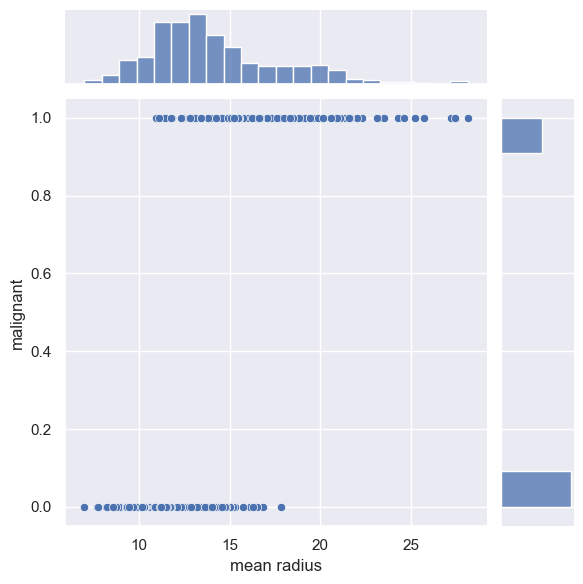

In [6]:
sns.jointplot(data = data, x = "mean radius", y = "malignant");
#savefig("overplot")

This is a clear example of over-plotting.  We can improve the above plot by jittering the data:

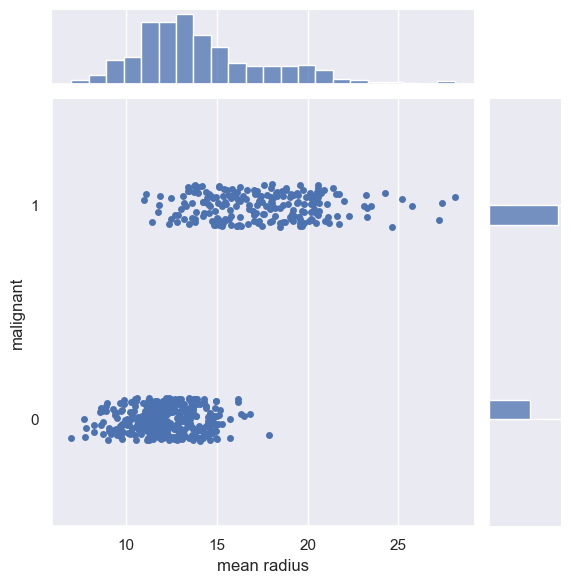

In [7]:
# manual to allow for jitter
g = sns.JointGrid(data = data, x = "mean radius", y = "malignant")
g.plot_marginals(sns.histplot)
g.plot_joint(sns.stripplot,
             orient='h', order=[1, 0],
             color=sns.color_palette()[0])
(g.ax_joint).set_xticks([10, 15, 20, 25])
plt.show()

Perhaps a better way to visualize the data is using stacked histograms.

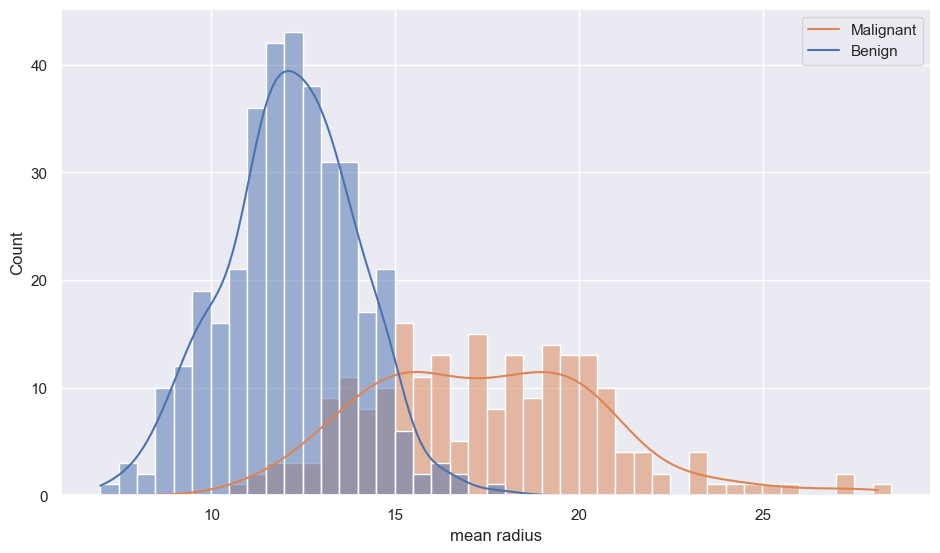

In [8]:
sns.histplot(data = data, x = "mean radius", hue = "malignant",
             binwidth=0.5,
             kde=True);
plt.legend(labels=["Malignant", "Benign"]);

**Question:** Looking at the above histograms could you describe a rule to predict whether or a cell is malignant?


### Preparing the Data Train-Test Split

Always split your data into training and validation sets.  

In [9]:
from sklearn.model_selection import train_test_split
data_tr, data_te = train_test_split(data, test_size=0.10, random_state=42)
data_tr.reset_index(inplace=True, drop=True)
data_te.reset_index(inplace=True, drop=True)
print("Training Data Size: ", len(data_tr))
print("Test Data Size: ", len(data_te))

Training Data Size:  512
Test Data Size:  57


Creating the `X` and `Y` matrices for the training data:

In [10]:
X = data_tr[['mean radius']].to_numpy()
Y = data_tr['malignant'].to_numpy()

## 1.2 Thought experiment (Poll / True of False)

In the problem, "Can the mean radius of the tumor ($X$) predict whether the tumor is malignant?", we take that $Y = 0$ if it's benign and $Y=1$ is the tumor is malignant.

Could I use linear regression to predict of $Y$ on $X$ and classify as "malignant" if $\hat Y > 0.5$?

(-0.5, 1.5)

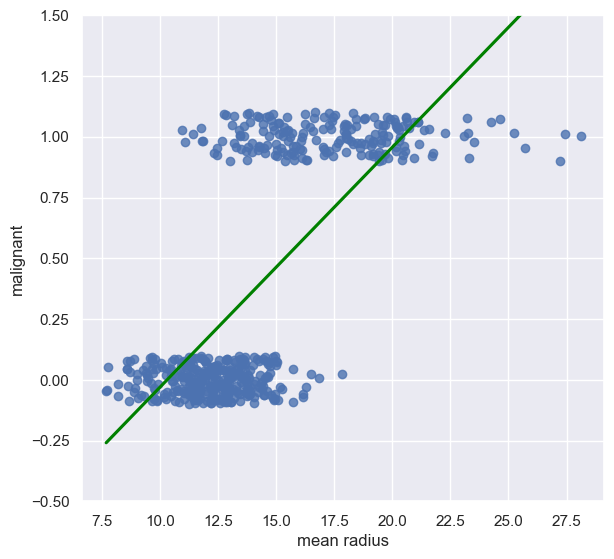

In [11]:
plt.figure(figsize=(6, 6))
sns.regplot(data=data_tr, x='mean radius', y='malignant', 
              y_jitter = 0.1, 
              ci=False,
              line_kws={'color':'green'});
plt.ylim((-0.5, 1.5))

### Thought experiment (cont.)

In this case of a binary outcome, linear regression might do a good job as a classifier.
It is a valid model:
+ assumes $y$ is continuous
+ It is the line that minimizes MSE for the training data

However, linear regression is not really the best choice here. There are many reasons for that:
+ The output ($y$) can be outside of the label range {0, 1}.
+ What does an output value of -2 mean? Possible classification: assign output > 0.5 to 1, and 0 otherwise.
+ Boundary very sensitive to outliers.

### Sensitivity to outliers

Suppose we had a training datapoint with extra-large $x$. See how least squares linear regression overfits to the large outlier point. It completely changes the classification for a large set of our datapoints.

In [12]:
data_out = data_tr[['mean radius', 'malignant']].copy()

# replace a datapont with a big outlier
# (mean radius = 120, malignant = 1) 
data_out.iloc[0, :2] = [120, 1]
data_out.head()

lin_reg = LinearRegression()
lin_reg.fit(data_tr[['mean radius']], data_tr['malignant'])
m, b = lin_reg.coef_[0], lin_reg.intercept_
vert_x = (0.5 - b)/m

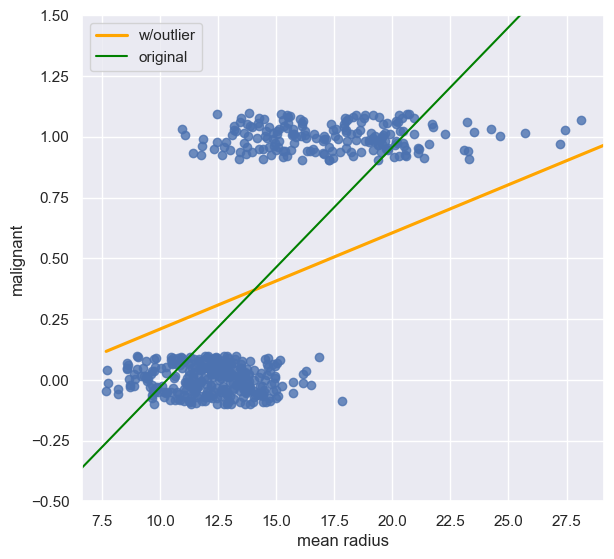

In [13]:
plt.figure(figsize=(6, 6))
sns.regplot(data = data_out, x = "mean radius", y = "malignant", 
              y_jitter = 0.1, 
              ci=False,
              line_kws={'color':'orange', 'label': 'w/outlier'},
           );
x_datapoints = np.array(plt.xlim())
plt.plot(x_datapoints, (x_datapoints)*m + b, color='green', label='original')
plt.ylim((-0.5, 1.5))
plt.xlim((6.67005, 29.13095))
plt.legend()

# 2. Deriving Logistic Regression

We need a better model. Let's try and work with an algorithmic version that resembles k-Nearst Neighbors (k-NN) and which we will revisit later.

Here is the procedure:
- We bin the $x$ axis.
- We take the average $y$ value for each bin on the $x$ axis (so we do majority voting).

In [14]:
# partition the training x data
bins = pd.cut(data_tr['mean radius'], 20) # Series of bin labels
data_tr['bin midpoint'] = [(b.left + b.right) / 2 for b in bins]

# then, get the average y per bin
avg_y_by_bin = data_tr.groupby('bin midpoint')['malignant'].mean()
avg_y_by_bin

bin midpoint
8.1915     0.000000
9.2225     0.000000
10.2435    0.000000
11.2645    0.057143
12.2855    0.094595
13.3065    0.200000
14.3275    0.333333
15.3485    0.674419
16.3695    0.750000
17.3900    0.944444
18.4105    1.000000
19.4315    1.000000
20.4525    1.000000
21.4735    1.000000
22.4945    1.000000
23.5155    1.000000
24.5365    1.000000
25.5575    1.000000
27.5995    1.000000
Name: malignant, dtype: float64

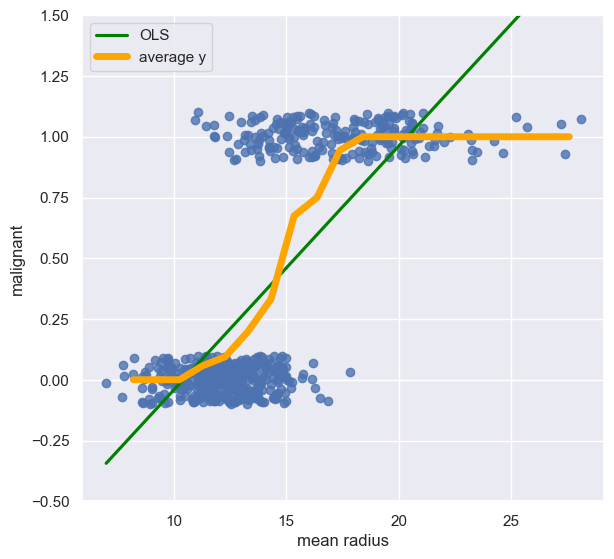

In [15]:
plt.figure(figsize=(6,6))
sns.regplot(data = data, x = "mean radius", y = "malignant", 
              y_jitter = 0.1, 
              ci=False,
              line_kws={'color':'green', 'label': 'OLS'},
           );

plt.plot(avg_y_by_bin, 'orange', linewidth = 5, label='average y');
plt.ylim((-0.5, 1.5))
plt.legend()

It seems like our orange line (aka the bin model) does a much better job at matching the data than our simple linear regression line.

**Question**: **What is this thing doing/plotting?**

For a given $x$, suppose its bin has the current $y$ as follows, producing the following average $y$:

$$ [0, 0, 1, 1, 1, 1, 0, 0, 0, 0] \rightarrow 0.4 $$

For this bin, the average y value is:
* A number between 0 and 1.
* The frequency of 1’s in the bin.

The average y for a bin is therefore a **probability**!!

$$P(Y = 1 | x) = \frac{\text{\# (y == 1) in bin}}{\text{\# datapoints in bin
}}$$

**Logistic regression aims to model the probability of an observation belonging to class 1, given some set of features.**

Logistic Regression is what we call a generalized linear model.
* Non-linear transformation of a linear model.
* Parameters are still a linear combination of x!

Let's try to derive the model.

### Step 1: Transform the y-axis non-linearly until the “S curve” looks linear.

First let's rename our variables from earlier so that we simplify some notation.

<Axes: xlabel='x', ylabel='p'>

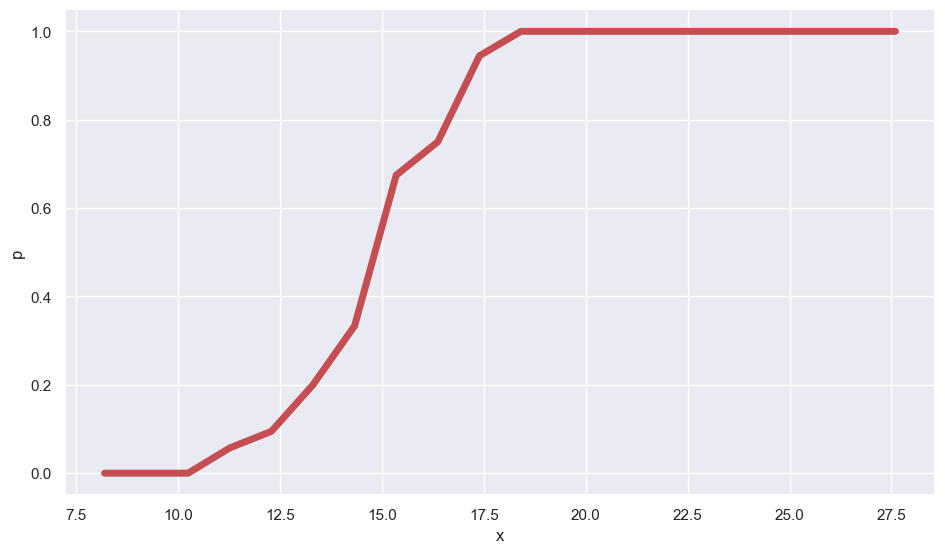

In [16]:
transform_df = pd.DataFrame({"x": avg_y_by_bin.index,
                        "p": avg_y_by_bin.values})

sns.lineplot(data=transform_df, x='x', y='p', color='r', linewidth = 5)

<br/>

The **odds** of an event are defined as the probability that it happens divided by the probability that it doesn't happen.

If some event happens with probability $p$, then 
<br/>

$$\text{odds}(p) = \frac{p}{1-p}$$

Let's compute the odds of of our probabilities.

If we plot these odds, they look exponential:

<Axes: xlabel='x', ylabel='odds'>

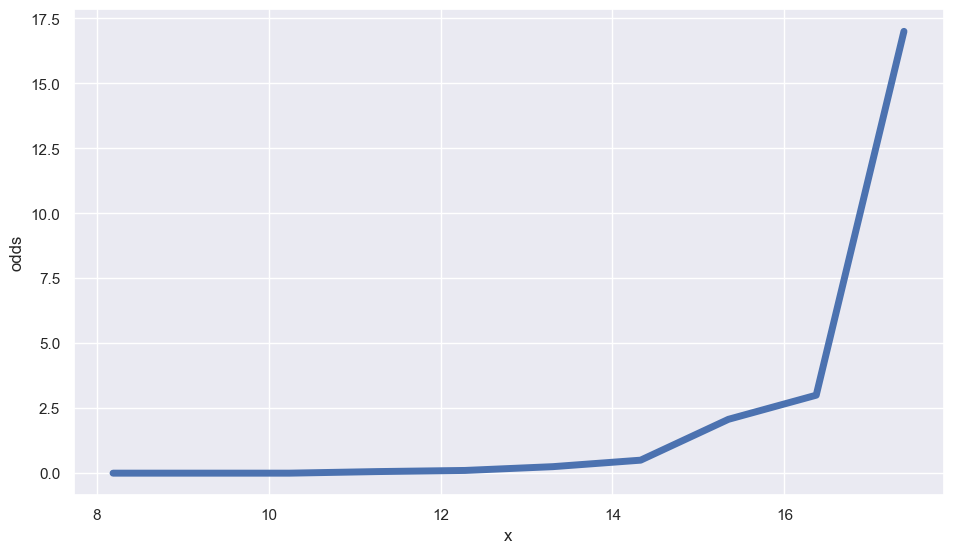

In [17]:
transform_df['odds'] = transform_df['p'] / (1 - transform_df['p'])

sns.lineplot(data=transform_df,
             x='x', y='odds', linewidth = 5)

But if we take the log of these odds:

c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

divide by zero encountered in log



<Axes: xlabel='x', ylabel='log-odds'>

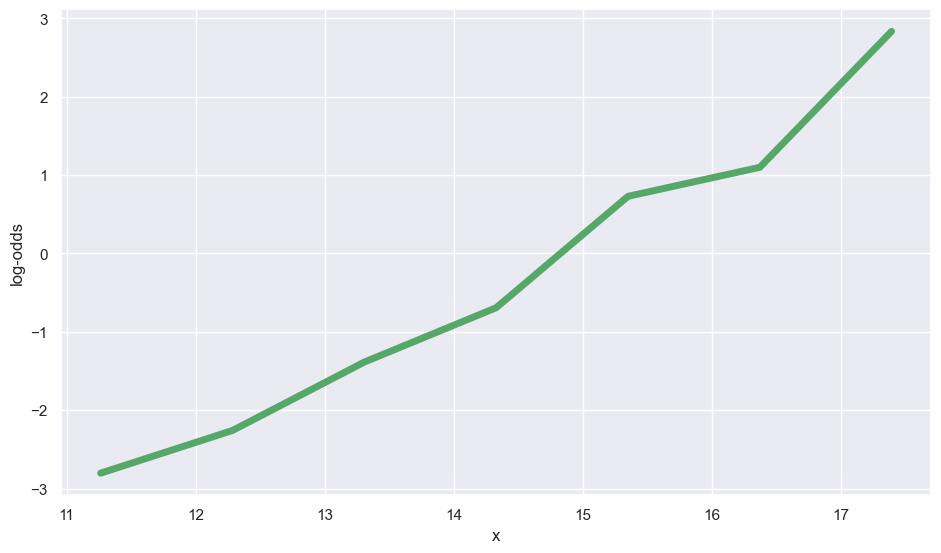

In [18]:
transform_df['log-odds'] = np.log(transform_df['odds'])

sns.lineplot(data=transform_df,
             x='x', y='log-odds',
             color='g', linewidth = 5)

### Step 2: use algebra to invert all transformations and derive the probability

(This portion is left to the lecture slides.)

# 3. Logistic regression 

In logistic regression, the categorical value, $Y$, that we predict only takes two values. We'll call them 0 and 1. 

**Main idea:** Given the predictor variable  X, we model the *probability* that $Y = 1$ by 
$$
p(X) = p(Y = 1 | \ X) = \frac{e^{\theta_0 + \theta_1 X}}{1+ e^{\theta_0 + \theta_1 X}}
$$

Defining the *logistic function* or *sigmoid function*,  
$$
\textrm{logistic}(x) := \frac{e^x}{1 + e^x} = \frac{1}{1+ e^{-x}},
$$
we can write the above expression more succinctly as 
$$
p(X) = \textrm{logistic}( \theta_0 + \theta_1 X ).  
$$

One can check that the model is equivalent to 
$$
\log \left( \frac{p(X)}{1-p(X)} \right) = \theta_0 + \theta_1 X. 
$$

Sometimes, the function on the left hand side of the above equation is called the *logit function*, 
$$
\textrm{logit}(p) := \log \left( \frac{p}{1-p} \right). 
$$
We can equivalently write the model as 

$$
\textrm{logit} ( p(X) ) = \theta_0 + \theta_1 X.  
$$
It follows that the logistic and logit functions are inverses of each other. 

**Interpretation:** We interpret $\frac{p(X)}{1-p(X)}$ as being the *odds* that $Y=1$. Note that $p(X)$ is a number between 0 and 1 so that the odds that $Y=1$ is a number between 0 and $\infty$. If $p(X) = 0.5$, then odds = 1.  We also have that $\textrm{logit} ( p(X) )$ is a number between $-\infty$ and $\infty$.

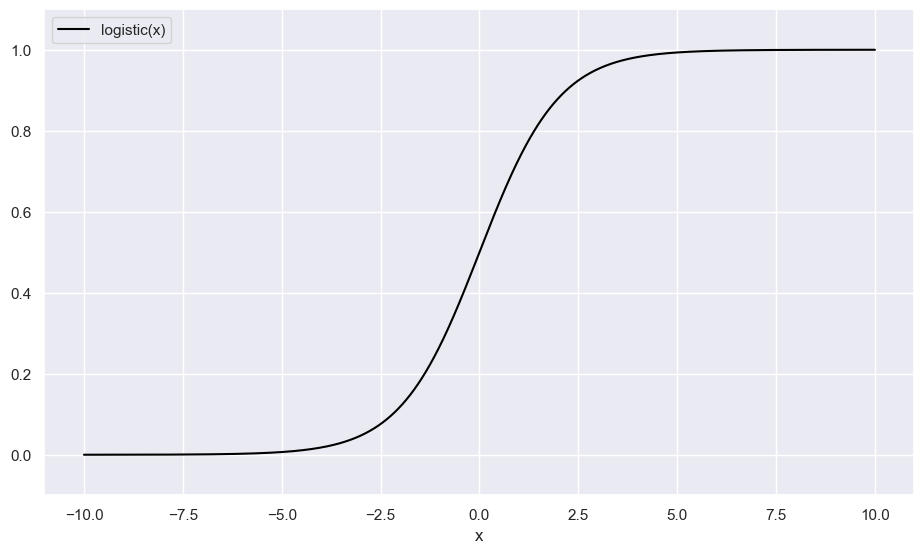

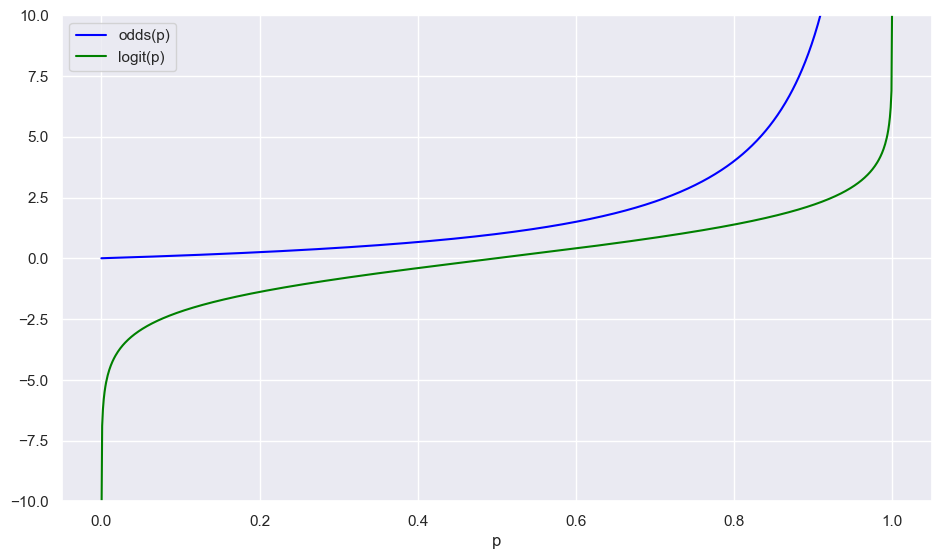

In [19]:
x = np.linspace(-10,10,1000)
logistic = lambda x: 1/(1+np.exp(-x))
plt.plot(x,logistic(x),color='black',label='logistic(x)')
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylim(-.1,1.1)
plt.show()

p = np.linspace(1e-5,1-1e-5,1000)
odds = lambda p: p/(1-p)
logit = lambda p: np.log(odds(p))
plt.plot(p,odds(p),color='blue',label='odds(p)')
plt.plot(p,logit(p),color='green',label='logit(p)')
plt.legend(loc='upper left')
plt.xlabel('p')
plt.ylim(-10,10)
plt.show()

## 3.1 How do I interpret the coefficient?

+ A one unit change in $X$ is associated with a $\theta_1$ change in the log-odds of $Y=1$ or a one unit change in $X$ is associated with an $e^{\theta_1}$ change in the odds that $Y = 1$.
+ $\theta_0$ shifts the curve right or left and $\theta_1$  controls how steep the $S$-shaped curve is.
+ If $\theta_1$ is positive, then the predicted $P (Y = 1)$ goes from 0 for small values of $X$ to 1 for large values of $X$ and if $\theta_1$ is negative, then$ P (Y = 1)$ has the opposite association.

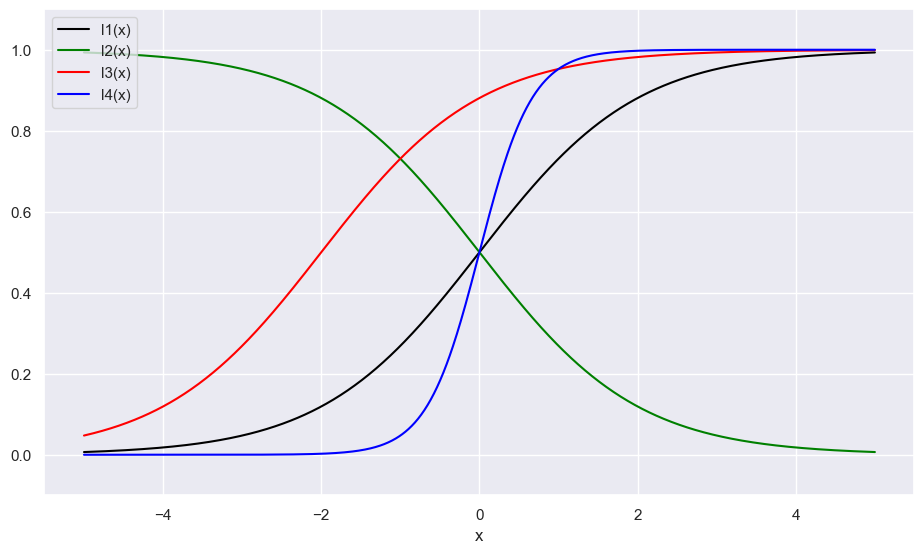

In [20]:
x = np.linspace(-5,5,1000)
l1 = lambda x: 1/(1+np.exp(0-x))
l2 = lambda x: 1/(1+np.exp(0+x))
l3 = lambda x: 1/(1+np.exp(-2-x))
l4 = lambda x: 1/(1+np.exp(0-3*x))
plt.plot(x,l1(x),color='black',label='l1(x)')
plt.plot(x,l2(x),color='green',label='l2(x)')
plt.plot(x,l3(x),color='red',label='l3(x)')
plt.plot(x,l4(x),color='blue',label='l4(x)')
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylim(-.1,1.1)
plt.show()

## 3.2 Logistic Regression in sklearn

The `linear_model.LogisticRegression` model ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) is what we want to use here. In order to recreate our specific model, there are a few parameters we need to set:
- `penalty = 'none'`: by default, `LogisticRegression` uses regularization. This is generally a good idea (but more will come later)
- `fit_intercept = True`: we will fit an intercept term.
- `solver = 'lbgfs'`: need to specify a numerical optimization routine for the model (similar to gradient descent). `lbfgs` is one such type; it's the new default in `scikit-learn`.

### a) Fit

We'll fit a model with the mean radius feature and a bias intercept. So $\theta = (\theta_0, \theta_1)$ and our model is:

$$\hat{P}_{\theta} (Y = 1 | x) = \sigma(x^T\theta) = \sigma(\theta_0 + \theta_1 x_1)$$

In [21]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=True, penalty=None)
model.fit(X, Y); # X, Y are training data

<br/>

Optimal $\theta_0, \theta_1$ from fitting our model:

In [22]:
model.intercept_, model.coef_

(array([-14.54277744]), array([[0.98731113]]))

### b) Prediction

**Predict probabilities**: `scikit-learn` has a built-in `.predict_proba` method that allows us to get the predicted probabilities under our model. The `.classes_` attribute stores our class labels.

In [23]:
model.predict_proba([[20]])

array([[0.00546753, 0.99453247]])

In [24]:
model.classes_

array([0, 1])

Let's visualize these probabilities on our train dataset, `X` and `y`.

In [25]:
Prob_hat_one = model.predict_proba(X)[:, 1]
Prob_hat_one.shape

(512,)

The seaborn function `stripplot` auto-plots jittered data by class.

Text(0, 0.5, 'y: class')

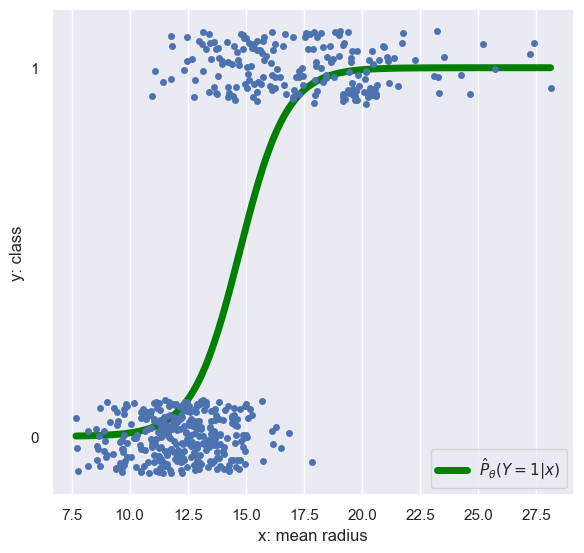

In [26]:
plt.figure(figsize=(6,6))
sns.stripplot(x=X.squeeze(), y=Y, 
              jitter = 0.1, orient='h');
sns.lineplot(x= X.squeeze(), y=Prob_hat_one,
             color='green', linewidth=5, label=r'$\hat{P}_{\theta}(Y = 1 | x)$')
plt.gca().invert_yaxis()
plt.xlabel('x: mean radius')
plt.ylabel('y: class')

**Predict class labels**: By comparison, what does `.predict()` do?

It predicts 1 if the computed probability for class 1 is greater than 0.5, and 0 otherwise.

$$\text{classify}(x) = \begin{cases} 1, & P(Y = 1 | x) \geq 0.5 \\ 0, & \text{otherwise} \end{cases}$$

This is what we call **classification**.

Edit the above cells to see sklearn's prediction for a mean radius of `10`.

In [27]:
model.predict([[20]])

array([1])

Let's build a DataFrame to store this information. We may need it later.

In [28]:
# in case you want to see all of the probabilities and predictions
def make_prediction_df(X, Y, model):
    # assume X has one feature and that model is already fit 
    Prob = model.predict_proba(X)
    Y_hat = model.predict(X)
    df = pd.DataFrame({"X": X.squeeze(),
                       "Y": Y,
                       "P(Y = 1 | x)": Prob[:,1],
                       "Y_hat": Y_hat})
    return df
    
predict_train_df = make_prediction_df(X, Y, model)
predict_train_df

,X,Y,P(Y = 1 | x),Y_hat
0,25.220,1,0.999968,1
1,13.480,1,0.225513,0
2,11.290,0,0.032420,0
3,12.860,0,0.136348,0
4,19.690,1,0.992589,1
...,...,...,...,...
507,8.888,0,0.003118,0
508,11.640,0,0.045197,0
509,14.290,0,0.393147,0
510,13.980,1,0.322967,0


## 3.3 Logistic Regression for more than one variables and/or for more than one classes

It's easy to extend to the model with one predictor to a model that accounts for multiple predictors.

$$
\log \left( \frac{p(X)}{1-p(X)} \right) = \theta_0 + \theta_1 X_1 + \theta_2 X_2 + ... + \theta_p X_p 
$$

or equivalently:

$$
p(X) = p(Y = 1 | \ X) = \frac{e^{\theta_0 + \theta_1 X_1 + \theta_2 X_2 + ... + \theta_p X_p}}{1+ e^{\theta_0 + \theta_1 X_1 + \theta_2 X_2 + ... + \theta_p X_p}}
$$

Same way, logisitc regression is easily generalized to more than two classes. How? By using the well-known *softmax* function as below:

$$
P(Y=k|X) = \frac{e^{\theta_{0k} + \theta_{1k} X_1 + \theta_{2k} X_2 + ... + \theta_{pk} X_p}}{\sum_{l=1}^K e^{\theta_{0l} + \theta_{1l} X_1 + \theta_{2l} X_2 + ... + \theta_{pl} X_p}}
$$

Each class gets one linear function (as above) and we weigh them against each other (that's what softmax does). Multiclass logistic regression is also referred to as multinomial  regression.

When there are more than 2 categories in the response  variable, then there is no guarantee that $P(Y = k) \geq 0.5$ for any one category. So any classifier based on logistic  regression will instead have to select the group with the  largest estimated probability. The classification boundaries are then much more difficult to  determine.

# 4. Loss function

(this part is explained in the slides)

# 5. Performance Metrics

Classification task: Given the `mean radius` of tumor cells in an image, predict if the tumor is malignant (1) or benign (0).

In [29]:
import sklearn.datasets

# load the data

data_dict = sklearn.datasets.load_breast_cancer()
data = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
# Target data_dict['target'] = 0 is malignant 1 is benign
data['malignant'] = (data_dict['target'] == 0).astype(int)

# split the data
from sklearn.model_selection import train_test_split
data_tr, data_te = train_test_split(data, test_size=0.10, random_state=42)
data_tr.reset_index(inplace=True, drop=True)
data_te.reset_index(inplace=True, drop=True)
print("Training Data Size: ", len(data_tr))
print("Test Data Size: ", len(data_te))

# X, Y are training data
X = data_tr[['mean radius']].to_numpy()
Y = data_tr['malignant'].to_numpy()

Training Data Size:  512
Test Data Size:  57


Back to the breast cancer dataset.

Here is our data:

In [30]:
# split the data
from sklearn.model_selection import train_test_split

# X, Y are training data
X = data_tr[['mean radius']].to_numpy()
Y = data_tr['malignant'].to_numpy()
X.shape, Y.shape

((512, 1), (512,))

In [31]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=True)
model.fit(X, Y); # X, Y are training data

Recall that sklearn's `model.predict()` will predict 1 if $P(Y = 1 | x) \geq 0.5$, and 0 otherwise.

<br/>

First, let's compute the **accuracy** of our `model` on our training dataset.



In [32]:
def accuracy(X, Y):
    return np.mean(model.predict(X) == Y)

accuracy(X, Y)

0.869140625

As per usual, `scikit-learn` can do this for us. The `.score` method of a `LogisticRegression` classifier gives us the accuracy of it.

In [33]:
model.score(X, Y)

0.869140625

### Confusion matrix

Our good old friend `scikit-learn` has an in-built confusion matrix method (of course it does).

In [34]:
from sklearn.metrics import confusion_matrix

# Be careful – confusion_matrix takes in y_true as the first parameter and y_pred as the second.
# Don't mix these up!
cm = confusion_matrix(Y, model.predict(X))
cm

array([[294,  23],
       [ 44, 151]], dtype=int64)

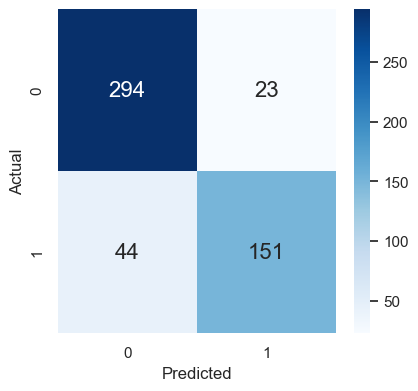

In [35]:
cm = confusion_matrix(Y, model.predict(X))
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

### Precision and Recall

We can also compute the number of TP, TN, FP, and TN for our classifier, and hence its precision and recall.

In [36]:
Y_hat = model.predict(X)
tp = np.sum((Y_hat == 1) & (Y == 1))
tn = np.sum((Y_hat == 0) & (Y == 0))

fp = np.sum((Y_hat == 1) & (Y == 0))
fn = np.sum((Y_hat == 0) & (Y == 1))
tp, tn, fp, fn

(151, 294, 23, 44)

In [37]:
cm # [tn, fp]
   # [fn, tp]

array([[294,  23],
       [ 44, 151]], dtype=int64)

These numbers match what we see in the confusion matrix above.

In [38]:
precision = tp / (tp + fp)
precision

0.867816091954023

In [39]:
recall = tp / (tp + fn)
recall

0.7743589743589744

It's important to remember that these values are all for the threshold of $T = 0.5$, which is `scikit-learn`'s default.

### Adjusting the Classification Threshold

What does a prediction of 1 mean with the default sklearn threshold of $T = 0.5$?

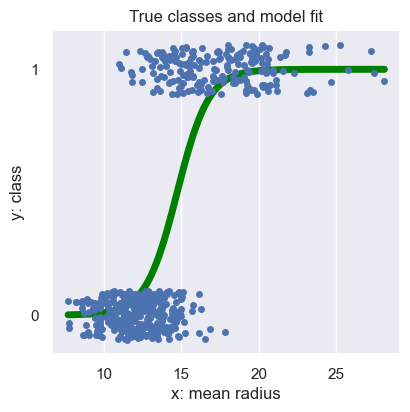

In [40]:
Prob_hat_one = model.predict_proba(X)[:, 1]

plt.figure(figsize=(4,4))
sns.stripplot(x=X.squeeze(), y=Y, 
              jitter = 0.1, orient='h');
sns.lineplot(x= X.squeeze(), y=Prob_hat_one,
             color='green', linewidth=5, label=r'$\hat{P}_{\theta}(Y = 1 | x)$')
plt.gca().invert_yaxis()
plt.xlabel('x: mean radius')
plt.ylabel('y: class')
plt.title("True classes and model fit")
plt.legend().remove()

Text(0.5, 1.0, 'Predicted classes if T = 0.5')

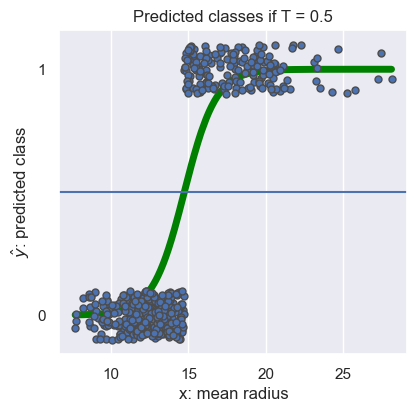

In [41]:
# predictions as well
Prob_hat_one = model.predict_proba(X)[:, 1]
Y_hat = model.predict(X) # threshold T = 0.5

plt.figure(figsize=(4,4))
sns.stripplot(x=X.squeeze(), y=Y_hat, 
              jitter = 0.1, orient='h', facecolors=None, linewidth=1);
sns.lineplot(x= X.squeeze(), y=Prob_hat_one,
             color='green', linewidth=5, label=r'$\hat{P}_{\theta}(Y = 1 | x)$')
plt.gca().invert_yaxis()
plt.axhline(y=0.5, label='T = 0.5')
plt.xlabel('x: mean radius')
plt.ylabel(r'$\hat{y}$: predicted class')
plt.legend().remove()
plt.title("Predicted classes if T = 0.5")

### Choosing a Threshold

What is the best threshold for a given performance metric?

### Accuracy

Accuracy threshold prediction on the train set:

In [42]:
bc_model = model        # fit to breast cancer dataset
def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)

def accuracy_threshold(X, Y, T):
    return np.mean(predict_threshold(bc_model, X, T) == Y)

In [43]:
# compute accuracies for different thresholds on train set
thresholds = np.linspace(0, 1, 100)
accs = [accuracy_threshold(X, Y, t) for t in thresholds]


fig = px.line(x=thresholds, y=accs, title="Train Accuracy vs. Threshold")
fig.update_xaxes(title="threshold")
fig.update_yaxes(title="Accuracy")

In [44]:
# the threshold that maximizes accuracy
np.argmax(accs)

57

In practice we should use cross validation:

In [45]:
from sklearn import metrics

# used for sklearn's cross_val_score
def make_scorer(metric, T):
    return lambda model, X, Y: metric(Y, predict_threshold(model, X, T)) 

def acc_scorer(T):
    return make_scorer(metrics.accuracy_score, T)

In [46]:
from sklearn.model_selection import cross_val_score
cv_accs = [
    np.mean(cross_val_score(bc_model, X, Y, 
                            scoring=acc_scorer(t), 
                            cv=5))
    for t in thresholds
]

In [47]:
fig = px.line(x=thresholds, y=cv_accs, title="Cross-Validated Accuracy vs. Threshold")
fig.update_xaxes(title="threshold")
fig.update_yaxes(title="Accuracy")

In [48]:
# the threshold that maximizes cross-validation accuracy
thresholds[np.argmax(cv_accs)]

0.5656565656565657

### ROC Curves

The choice of threshold $T$ impacts our classification perfromance.
+ A high $T$ means that most predictions are 0. I expect lots of false negatives.
+ A low $T$ means that most predictions are 1. I expect lots of false positives.

First let's plot both TPR vs. threshold and FPR vs. threshold.

+ True Positive Rate (TPR):

$TPR = \frac{TP}{TP+FN}$

<br>
“What proportion of spam did I mark correctly? Same thing as recall. In statistics, sensitivity.

+ False Positive Rate (FPR):

$FPR = \frac{FP}{FP+TN}$

<br>
“What proportion of regular email did I mark as spam? In statistics, also called 1-specificity.

In [49]:
bc_model = model        # fit to breast cancer dataset
def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)


def tpr_threshold(X, Y, T): # this is recall
    Y_hat = predict_threshold(bc_model, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y == 1)

def fpr_threshold(X, Y, T):
    Y_hat = predict_threshold(bc_model, X, T)
    return np.sum((Y_hat == 1) & (Y == 0)) / np.sum(Y == 0)


In [50]:
# compute for different thresholds on train set
thresholds = np.linspace(0, 1, 100)
tprs = [tpr_threshold(X, Y, t) for t in thresholds]
fprs = [fpr_threshold(X, Y, t) for t in thresholds]

First we plot the TPR and FPR rates vs. threshold:

In [51]:
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'TPR', x = thresholds, y = tprs))
fig.add_trace(go.Scatter(name = 'FPR', x = thresholds, y = fprs))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Proportion")

Some observations:
* T = 0 means everything is positive.
    * Then there are no TN (all of them are FP). → FPR = 1
    * We identified all true 1’s as 1, so TPR = recall = 1
* T = 1 means everything is negative.
    * Then there are no FP (all of them are TN). → FPR = 0
    * We identified zero true 1’s as 1, so TPR = recall = 0

In other words, TPR and FPR are both inversely proportional to the classification threshold T.

As we increase T, both TPR and FPR decrease.
* A decreased TPR is bad (detecting fewer positives).
* A decreased FPR is good (fewer false positives).

The ROC curve plots this tradeoff (between TPR and FPR). We want high TPR, low FPR.

We plot it below.

In [52]:
fig = px.line(x=fprs, y = tprs, hover_name=thresholds, title="ROC Curve")
fig.update_xaxes(title="False Positive Rate")
fig.update_yaxes(title="True Positive Rate")
fig

Observations

+ The “perfect” classifier is the one that has a TPR of 1, and FPR of 0.
+ We want our logistic regression model to match that as well as possible.
+ We want our ROC curve to be as close to the “top left” of this graph as possible.

We can compute the area under curve (AUC) of our model.
+ Different AUCs for both ROC curves and PR curves, but ROC is more common.
+ Best possible AUC = 1. Terrible AUC = 0.5 (Random predictors have an AUC of around 0.5)
+ Your model’s AUC: somewhere between 0.5 and 1.

# 6. The two moons

In [53]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.datasets import make_moons, load_iris
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## 6.1 Logistic Regression on two moons

Let's consider a synthetic dataset in the shape of "two moons". Here, each sample has two pieces of information: 
* the *features*, denoted by $x_i$, which are just a two-dimensional coordinate and 
* a *class*, denoted by $y_i$, which is either 0 and 1. 

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(500, 2) (500,)
[[ 0.50316464  0.11135559  1.        ]
 [ 1.06597837 -0.63035547  1.        ]
 [ 0.95663377  0.58199637  0.        ]
 [ 0.33961202  0.40713937  0.        ]
 [ 2.17952333 -0.08488181  1.        ]
 [ 2.00520942  0.7817976   1.        ]
 [ 0.12531776 -0.14925731  1.        ]
 [ 1.06990641  0.36447753  0.        ]
 [-0.76391099 -0.6136396   0.        ]
 [ 0.55678871  0.8810501   0.        ]]


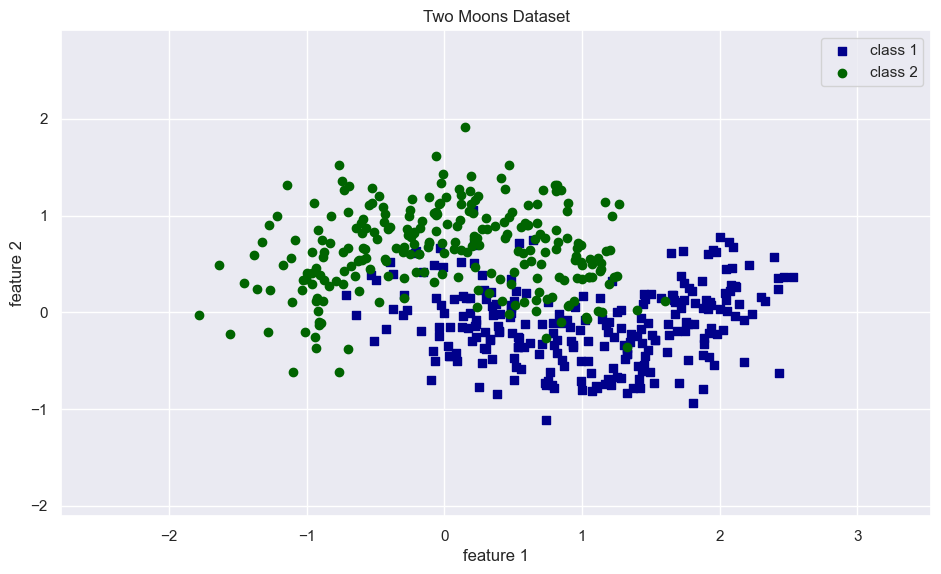

In [54]:
# there are two features contained in X and the labels are contained in y
X,y = make_moons(n_samples=500,random_state=1,noise=0.3)

# X is a 500x2 numpy.ndarray containing the coordinates for each sample
# y is a 500x1 numpy.ndarray containing the class for each sample
print(type(X), type(y)) 
print(np.shape(X), np.shape(y))

print(np.concatenate((X,y[:, np.newaxis]),axis=1)[:10,:])

# Plot the data, color by class
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="DarkBlue", marker="s",label="class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="DarkGreen", marker="o",label="class 2")
plt.legend(scatterpoints=1)

x_min, x_max = X[:,0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title('Two Moons Dataset')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

Recall that the goal in **classification** is to develop a rule for classifying the points.

Let's see how to use  [scikit-learn](http://scikit-learn.org/) for logistic regression. 

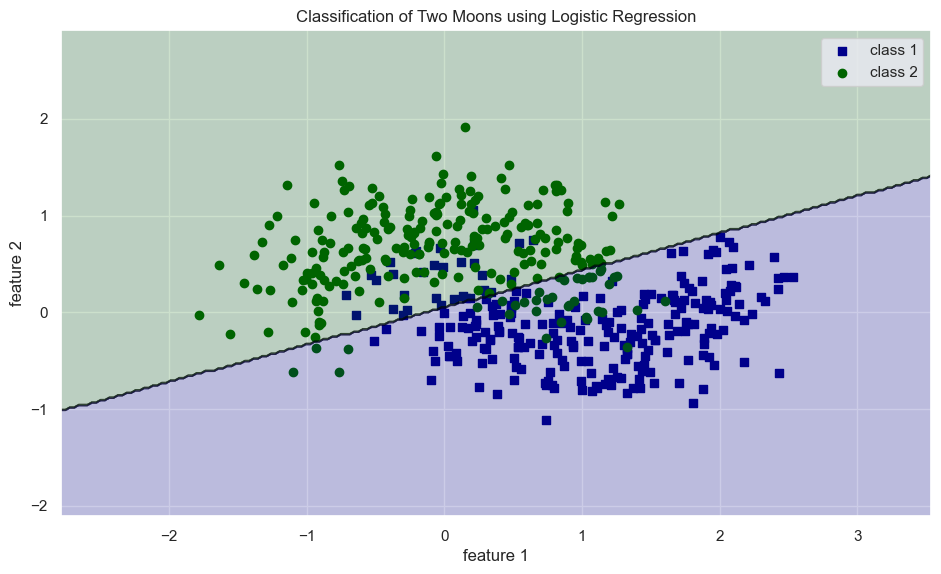

In [55]:
# set up the model 
# we could specify additional parameters here, but we'll just use the default ones
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# Documentation has more info (e.g. how to do the multinomial regression)
model = LogisticRegression() 

# use the model to fit the data
model.fit(X, y)

# Plot the data, color by class
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="DarkBlue", marker="s",label="class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="DarkGreen", marker="o",label="class 2")
plt.legend(scatterpoints=1)

# Plot the predictions made by Logistic Regression
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),np.linspace(y_min, y_max, 200))
zz = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, zz, cmap=ListedColormap(['DarkGreen', 'DarkBlue']), alpha=.2)
plt.contour(xx, yy, zz, colors="black", alpha=1, linewidths=0.2) 

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Classification of Two Moons using Logistic Regression')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()

In [56]:
print('Confusion Matrix:')
y_pred = model.predict(X)
print(metrics.confusion_matrix(y_true = y, y_pred = y_pred))

print('Precision = ', metrics.precision_score(y_true = y, y_pred = y_pred))
print('Recall = ', metrics.recall_score(y_true = y, y_pred = y_pred))
print('F-score = ', metrics.f1_score(y_true = y, y_pred = y_pred))

print('Jaccard similarity score', metrics.jaccard_score(y_true = y, y_pred = y_pred))

Confusion Matrix:
[[212  38]
 [ 32 218]]
Precision =  0.8515625
Recall =  0.872
F-score =  0.8616600790513834
Jaccard similarity score 0.7569444444444444


## 6.2 Let's compare with another classification algorithm: k-Nearest Neighbors (k-NN) 

**Idea:** To decide the class of a given point, find the $k$-nearest neighbors of that point, and let them "vote" on the class. That is, we assign the class to the sample that is most common among its $k$-nearest neighbors. 

**Considerations:**
1. We must pick $k$, the number of voting neighbors (typically a small number, say $k$=10)
+ 'Nearest' means closest in distance, so there is some flexibility in defining the distance. Can you name me some of your favorite distance measures?
+ There are different ways to vote. For example, of the k nearest neighbors, I might give the closest ones more weight than farther ones. 
+ We have to decide how to break ties in the vote. 

### Example: k-NN on the moons dataset

In [57]:
# there is a warning when running the k-NN classifier due to a future change in scipy.
# here we ignore it, a good idea would be to fix it
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [58]:
# moons
X,y = make_moons(n_samples=500,random_state=1,noise=0.3)

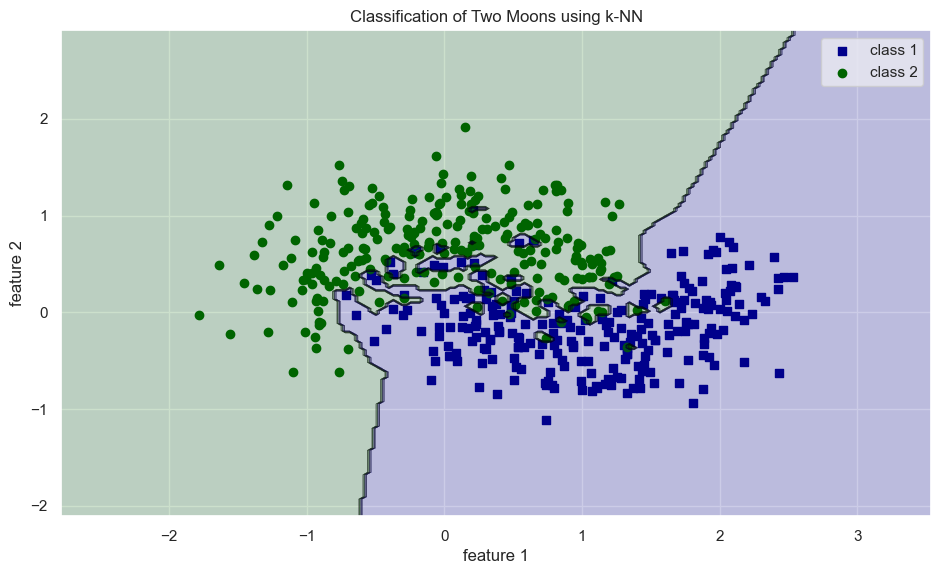

In [89]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X, y)

# Plot the data, color by class
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="darkblue", marker="s",label="class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="darkgreen", marker="o",label="class 2")
plt.legend(scatterpoints=1)

# Plot the predictions made by Logistic Regression
x_min, x_max = X[:,0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),np.linspace(y_min, y_max, 200))
zz = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, zz, cmap=ListedColormap(['DarkGreen', 'DarkBlue']), alpha=.2)
plt.contour(xx, yy, zz, colors="black", alpha=1, linewidths=0.2) 

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.title('Classification of Two Moons using k-NN')

plt.show()

### POLL:

In the case of $k$-NN, as $k$ increases what happens to the variance of the model?

A. increases <br>
B. decreases <br> 
C. stays the same  <br>
D. first increases and then decreases  <br>
E. first decreases and then increases  <br>
F. unicorns love bananas <br>

**Some comments on the parameter, $k$:** 

- For k large (say $k=100$), the *decision boundary* (boundary between classes) is smooth (but curved). The model is not very complex - it could basically be described by a few lines (polynomial perhaps?). The model has low variance in the sense that if the data were to change slightly, the model wouldn't change much (why? because there are many voters). Since the model doesn't depend on the data very much, we might expect that it would *generalize* to new data points. 

- For k small (say $k=1$), the decision boundary is very wiggly. The model is very complex - it definitely can't be described by a few lines. The model has high variance in the sense that if the data were to change slightly, the model would change quite a bit. Since the model is very dependent on the dataset, we would say that it wouldn't generalize to new data points well. In this case, we would say that the model has overfit the data (e.g. in the case of the high degree polynomial).

**Questions:**
1. Which does a better job on the two moons dataset: k-NN or logistic regression?
2. How to choose k?

In [91]:
print('Confusion Matrix:')
y_pred = model.predict(X)
print(metrics.confusion_matrix(y_true = y, y_pred = y_pred))

print('Precision = ', metrics.precision_score(y_true = y, y_pred = y_pred))
print('Recall = ', metrics.recall_score(y_true = y, y_pred = y_pred))
print('F-score = ', metrics.f1_score(y_true = y, y_pred = y_pred))

print('Jaccard similarity score', metrics.jaccard_score(y_true = y, y_pred = y_pred))

Confusion Matrix:
[[250   0]
 [  0 250]]
Precision =  1.0
Recall =  1.0
F-score =  1.0
Jaccard similarity score 1.0


For *good* choices of the parameter k, k-NN has better performance than logistic regression. Logistic regression suffers because the decision boundary isn't curved. For this reason, it is called a *linear classifier*.  (However there are extensions to logistic regression that allow the decision boundary to curve). 


# 7. Model generalizability and cross-validation

In classification, and other prediction problems (like regression), we would like to develop a model on a dataset, the *training dataset*, that will not only perform well on that dataset but on similar data that the model hasn't yet seen, the *testing dataset*. If a model satisfies this criterion, we say that it is *generalizable*. 

If a model has 100% accuracy on the training dataset ($k=1$ in k-NN) but doesn't generalize to new data, then it isn't a very good model. We say that this model has *overfit* the data. On the other hand, it isn't difficult to see that we could also *underfit* the data (taking $k$ large in k-NN). In this case, the model isn't complex enough to have good accuracy on the training dataset. 

We can use cross-validation (as in regression) to determine how generalizable our model is. A general reminder about the general cross-validation process (here we do not use a validation set and we do not use $K$-fold cross-validation):

1. Split the dataset into two groups: the training dataset and the test dataset. 
+ Train the model on the training dataset 
+ Check the accuracy of the model on the test dataset. 

Let's see this concept for the two moons dataset. We use the *train_test_split* function in scikit-learn to split the dataset into a training dataset and a test dataset. 

In [61]:
#from a medium blog that I can't find anymore 

def detect_plot_dimension(X, h=0.02, b=0.05):
    x_min, x_max = X[:, 0].min() - b, X[:, 0].max() + b
    y_min, y_max = X[:, 1].min() - b, X[:, 1].max() + b
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    dimension = xx, yy
    return dimension
 
def detect_decision_boundary(dimension, model):
    xx, yy = dimension  # unpack the dimensions
    boundary = model.predict(np.c_[xx.ravel(), yy.ravel()])
    boundary = boundary.reshape(xx.shape)  # Put the result into a color plot
    return boundary
 
def plot_decision_boundary(panel, dimension, boundary, colors=['#DADDED', '#FBD8D8']):
    xx, yy = dimension  # unpack the dimensions
    panel.contourf(xx, yy, boundary, cmap=ListedColormap(colors), alpha=1)
    panel.contour(xx, yy, boundary, colors="g", alpha=1, linewidths=0.5)  # the decision boundary in green
 
def plot_dataset(panel, X, y, colors=["#EE3D34", "#4458A7"], markers=["x", "o"]):
    panel.scatter(X[y == 1, 0], X[y == 1, 1], color=colors[0], marker=markers[0])
    panel.scatter(X[y == 0, 0], X[y == 0, 1], color=colors[1], marker=markers[1])
 
def calculate_prediction_error(model, X, y):
    yPred = model.predict(X)
    score = round(metrics.accuracy_score(y, yPred), 2)
    return score
 
def plot_prediction_error(panel, dimension, score, b=.3):
    xx, yy = dimension  # unpack the dimensions
    panel.text(xx.max() - b, yy.min() + b, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
 
def explore_fitting_boundaries(model, n_neighbors, datasets, width):  
    # determine the height of the plot given the aspect ration of each panel should be equal
    height = float(width)/len(n_neighbors) * len(datasets.keys())
 
    nrows = len(datasets.keys())
    ncols = len(n_neighbors)
 
    # set up the plot
    figure, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(width, height),
        sharex=True,
        sharey=True
    )
 
    dimension = detect_plot_dimension(X, h=0.02)  # the dimension each subplot based on the data
 
    # Plotting the dataset and decision boundaries
    i = 0
    for n in n_neighbors:
        model.n_neighbors = n
        model.fit(datasets["Training Set"][0], datasets["Training Set"][1])
        boundary = detect_decision_boundary(dimension, model)
        j = 0
        for d in datasets.keys():
            try:
                panel = axes[j, i]
            except (TypeError, IndexError):
                if (nrows * ncols) == 1:
                    panel = axes
                elif nrows == 1:  # if you only have one dataset
                    panel = axes[i]
                elif ncols == 1:  # if you only try one number of neighbors
                    panel = axes[j]
            plot_decision_boundary(panel, dimension, boundary)  # plot the decision boundary
            plot_dataset(panel, X=datasets[d][0], y=datasets[d][1])  # plot the observations
            score = calculate_prediction_error(model, X=datasets[d][0], y=datasets[d][1])
            plot_prediction_error(panel, dimension, score, b=0.2)  # plot the score
 
            # make compacted layout
            panel.set_frame_on(False)
            panel.set_xticks([])
            panel.set_yticks([])
 
            # format the axis labels
            if i == 0:
                panel.set_ylabel(d)
            if j == 0:
                panel.set_title('k={}'.format(n))
            j += 1
        i += 1   
 
    plt.subplots_adjust(hspace=0, wspace=0)  # make compacted layout

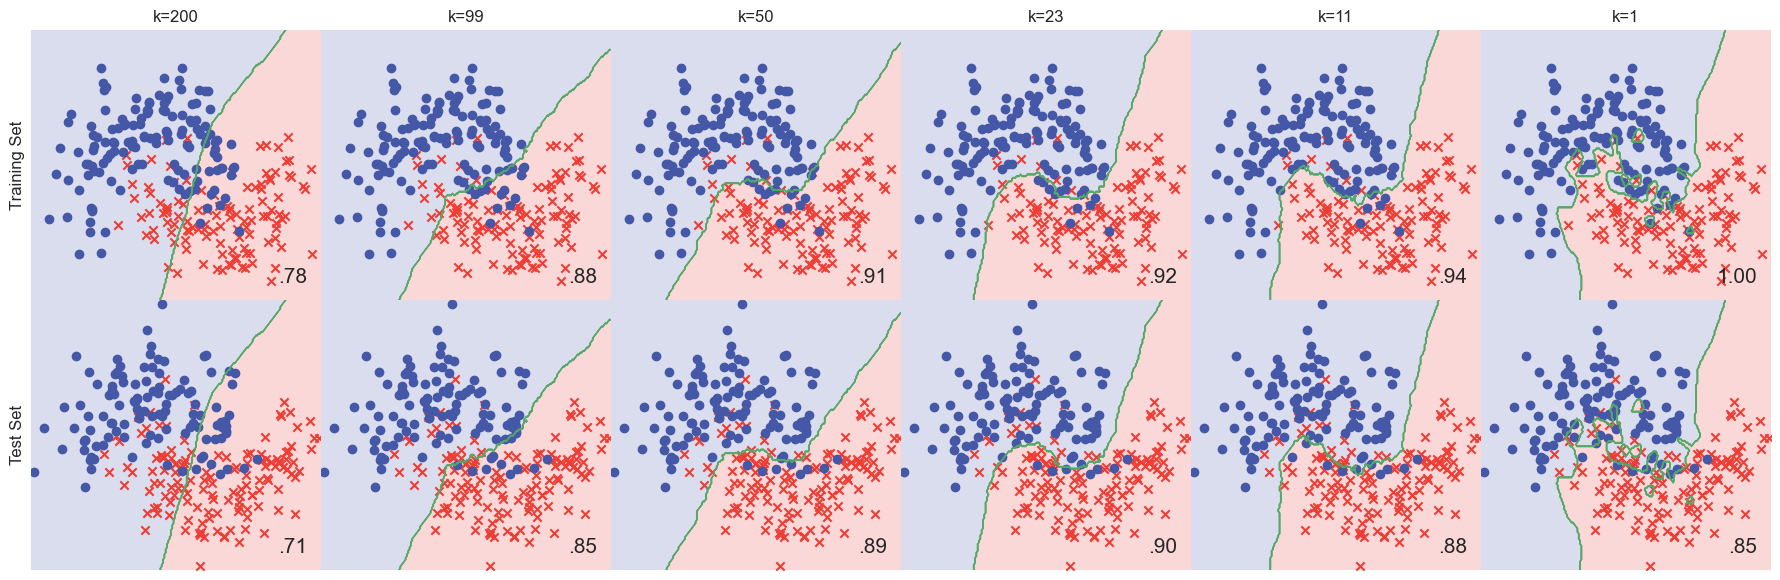

In [62]:
# Split into training and test sets
XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.5)

# specify the model and settings
model = KNeighborsClassifier()
n_neighbors = [200, 99, 50, 23, 11, 1]
datasets = {
    "Training Set": [XTrain, yTrain],
    "Test Set": [XTest, yTest]
}
width = 20

explore_fitting_boundaries(model=model, n_neighbors=n_neighbors, datasets=datasets, width=width)


### Classification method preview

We saw how Logistic Regression compares to $k$-NN and what is the added value of $k$-NN (i.e. introducing non-linearities). We will continue looking at non-linear models in the next lecture.

For a quick preview of other classification methods, see the comparison [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)


# 8. Further extensions of the linear model

Previously we discussed extensions of the linear model

* Classification problems: Logistic regression, etc. (check vv)

* Regularized fitting: (check vv)

* Interactions: Tree-based methods (bagging, boosting, etc.) (we see this in the next lecture)

* Non-linearity: splines, generalized additive models, etc.

Except for the tree-based models (that we see in the next lecture), there are many extensions of the linear model that allows handling non-linearities but at the same time maintain the ease and interpretability of the linear model. Such examples are:

+ polynomials (we saw these already),
+ step functions, 
+ splines, 
+ local regression,
+ generalized additive models

# Appendix

## 9. Why Squared Loss is bad for Logistic Regression

We've chosen a model. It's now time to choose a loss function. Why not squared loss?

Recall our model is $$\hat{P}_{\theta}(Y=1 \mid x) = \sigma(x^{\top}\theta).$$

Using Mean Sqaured Loss, we have $$R(\theta) = \frac{1}{n}\sum_{i=1}^{n} (y_i - \sigma(x_i^{\top}\theta))^2.$$ Let's try it out.

In [63]:
# the logistic function
# known as the sigmoid function in ML
def sigma(t):
    return 1 / (1 + np.exp(-t))

def mse_loss_train_nobias(theta):
    x = data_tr['mean radius']
    y_obs = data_tr['malignant']
    y_hat = sigma(x * theta)
    return np.mean((y_hat - y_obs) ** 2)  

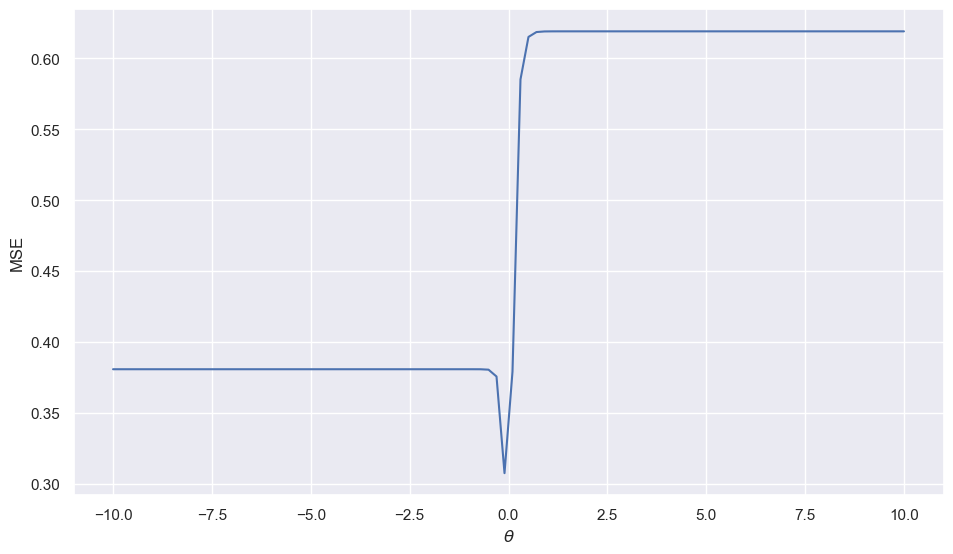

In [64]:
thetas = np.linspace(-10, 10, 100)
plt.plot(thetas, [mse_loss_train_nobias(theta) for theta in thetas])
plt.ylabel('MSE')
plt.xlabel(r'$\theta$');

What????

## Toy Dataset: L2 Loss

Consider this manufactured dataset.

In [65]:
toy_df = pd.DataFrame({
        "x": [-4, -2, -0.5, 1, 3, 5],
        "y": [0, 0, 1, 0, 1, 1]
        #"x": [-9.5, -5.8, -4.0, 8.7, 12.0],
        #"y": [1, 0, 0, 1, 0]
})
toy_df.sort_values("x")

,x,y
0,-4.0,0
1,-2.0,0
2,-0.5,1
3,1.0,0
4,3.0,1
5,5.0,1


Text(0.5, 1.0, 'Toy classification data')

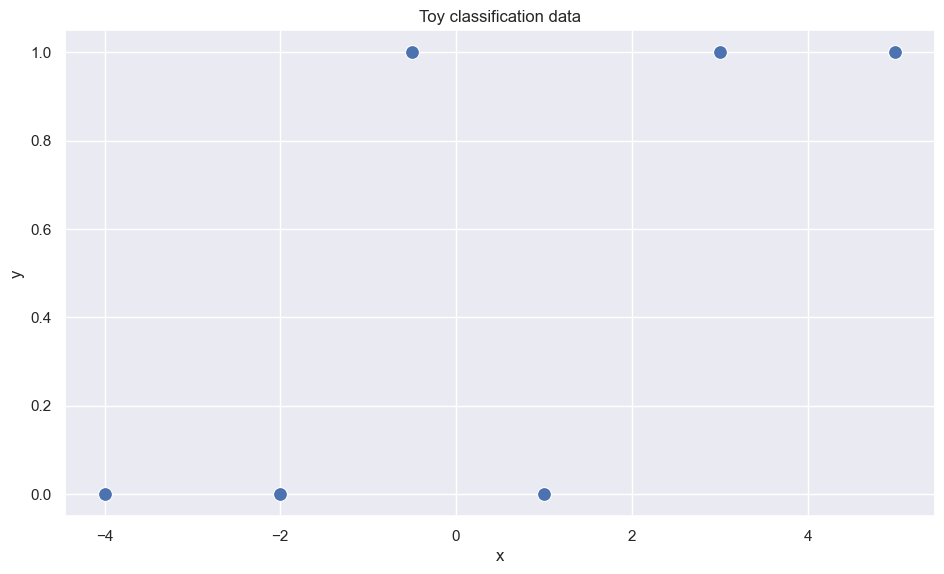

In [66]:
sns.scatterplot(data=toy_df, x='x', y='y', s=100, color="b")
plt.title("Toy classification data")

Let's plot the loss surface for this toy data using squared loss with the model $\hat{p} = \sigma(\theta x)$. We don't include an intercept term, so $\theta$ and $x$ are both scalars.

Text(0, 0.5, 'MSE')

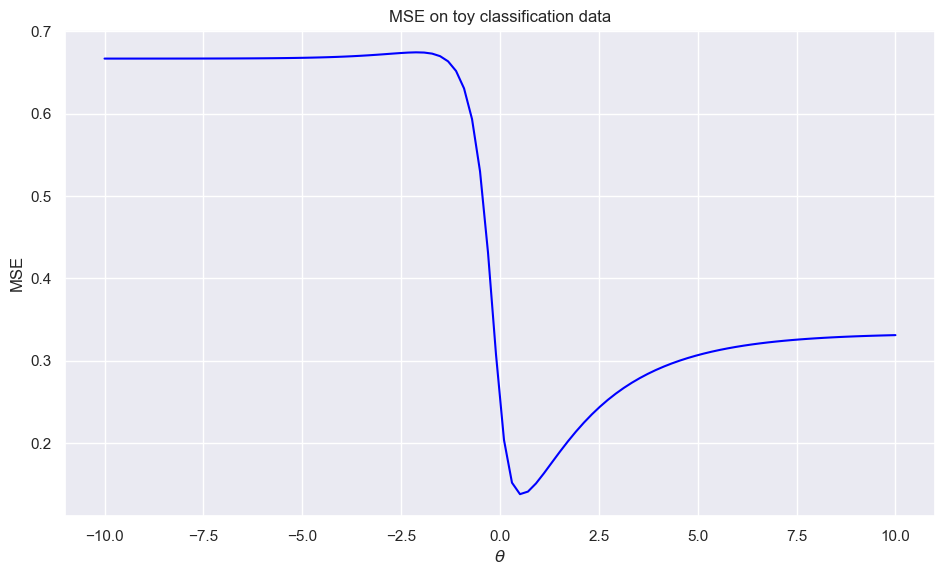

In [67]:
def mse_loss_toy_nobias(theta):
    p_hat = sigma(toy_df['x'] * theta)
    return np.mean((toy_df['y'] - p_hat)**2)

thetas = np.linspace(-10, 10, 100)
plt.plot(thetas, [mse_loss_toy_nobias(theta) for theta in thetas], color="blue")
plt.title("MSE on toy classification data");
plt.xlabel(r'$\theta$')
plt.ylabel('MSE')

This loss surface is not convex! Depending on where we start our optimization search, we'll end up with different results. Let's explore with `scipy.optimize.minimize`.

In [68]:
from scipy.optimize import minimize

best_theta = minimize(mse_loss_toy_nobias, x0 = 0)["x"][0]
best_theta

0.5446601825581691

Remember, our 1-D model with no intercept is $\hat{p} = \sigma(\theta x)$.

Text(0.5, 1.0, '$\\hat{\\theta} = $0.5447')

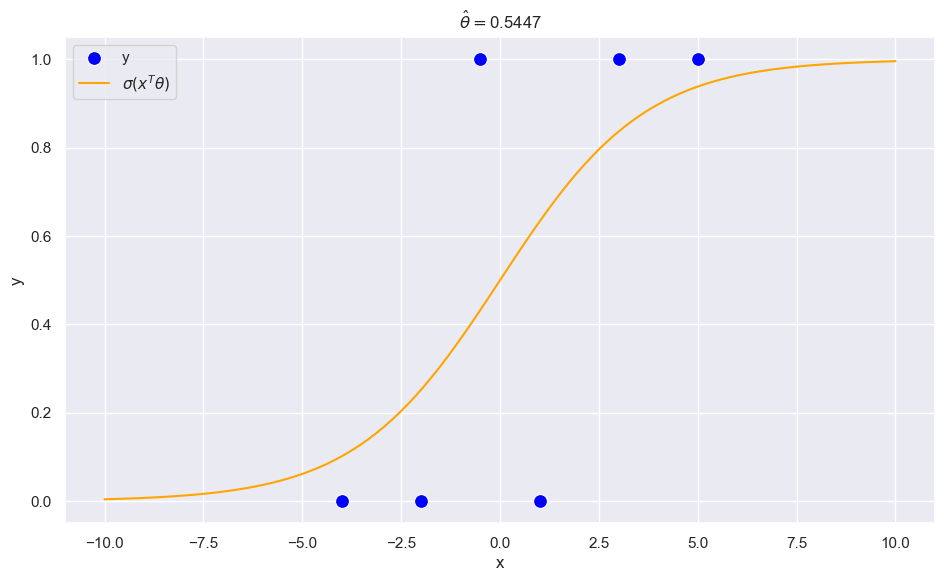

In [69]:
sns.scatterplot(data=toy_df, x='x', y='y', s=100, label='y', color="blue")
xs = np.linspace(-10, 10, 100)
plt.plot(xs, sigma(xs * best_theta), color='orange', label=r'$\sigma(x^T \theta)$')
plt.xlabel('x')
plt.legend()
plt.title(r'$\hat{\theta} = $' + f"{best_theta:.4}")

<br/>
Let's try another starting point for minimizing theta.

In [70]:
best_theta_2 = minimize(mse_loss_toy_nobias, x0 = -5)["x"][0]
best_theta_2

-10.343653061026611

Uhhh, looks like the optimizer got stuck.

Text(0.5, 1.0, '$\\hat{\\theta} = $-10.34')

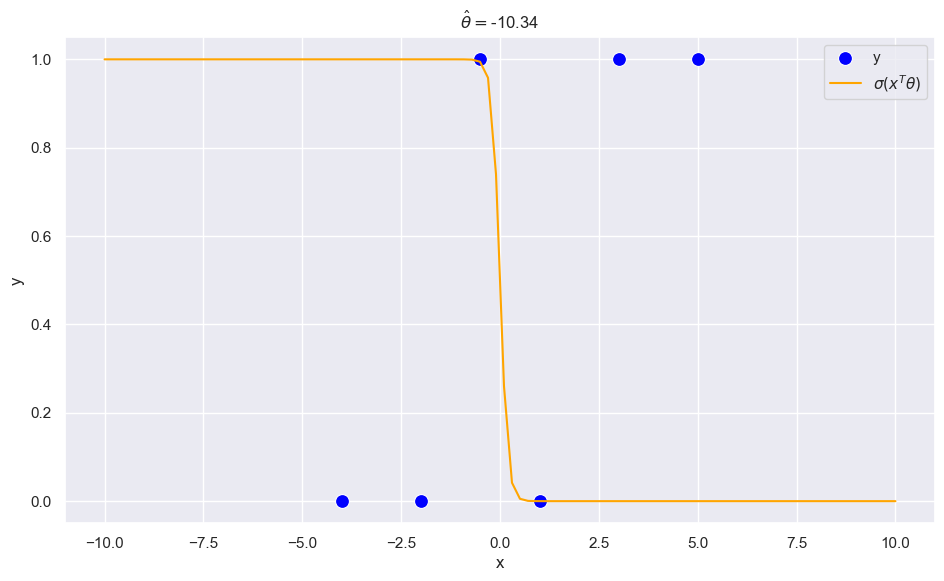

In [71]:
sns.scatterplot(data=toy_df, x='x', y='y', s=100, label='y', color="blue")
xs = np.linspace(-10, 10, 100)
plt.plot(xs, sigma(xs * best_theta_2), color='orange', label=r'$\sigma(x^T \theta)$')
plt.xlabel('x')
plt.legend()
plt.title(r'$\hat{\theta} = $' + f"{best_theta_2:.4}")

Not only is it not convex, leading to the weird issues above, but squared loss just isn't well-suited for a probability task. Since $\hat{p}_i$ is between 0 and 1, and $y_i$ is either 0 or 1, the squared loss for a single point $(y_i - \hat{p}_i)^2$ is bounded between 0 and 1.

What this means in practice: even if our prediction is terrible, the squared loss is never that large.

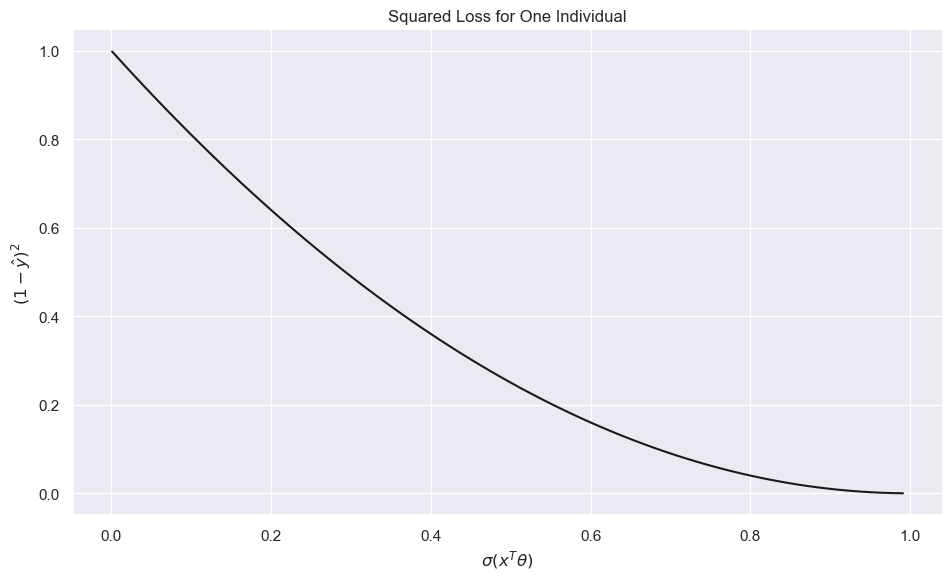

In [72]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = (1 - p_hat)**2
plt.plot(p_hat, loss, color='k')
plt.xlabel(r'$\sigma({x^T \theta})$')
plt.ylabel(r'$(1 - \hat{y})^2$')
plt.title('Squared Loss for One Individual');

## Motivating Cross-Entropy Loss

Let's look at a new loss, called the log loss, for when our true observation is 1.

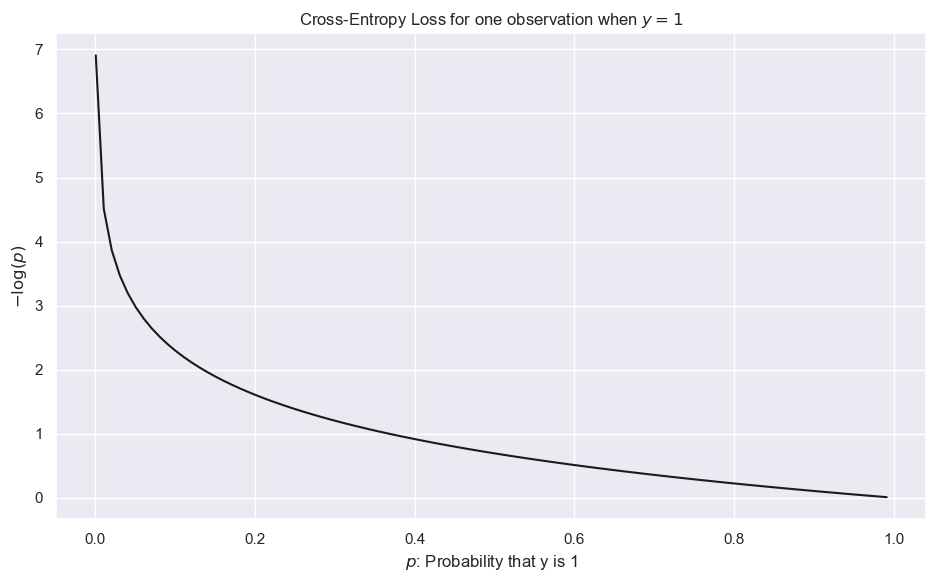

In [73]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(p_hat)
plt.plot(p_hat, loss, color='k')
plt.xlabel('$p$: Probability that y is 1')
plt.ylabel('$-\log(p)$')
plt.title('Cross-Entropy Loss for one observation when $y = 1$');

We can see that this penalizes wrong predictions far more than squared loss does.

How to read this plot: Suppose the observation we're trying to predict is actually in class 1. If our model gives an 80% chance of being in class 1, the loss is relatively small (around 0.25). 

If we give only a 40% of being in class 1, the loss is larger (around 1).

If we give only a 5% chance of being in class 1, the loss is 3.

And if we give a 0% chance of being in class 1, the loss is infinite.

What about when the true observation is 0?

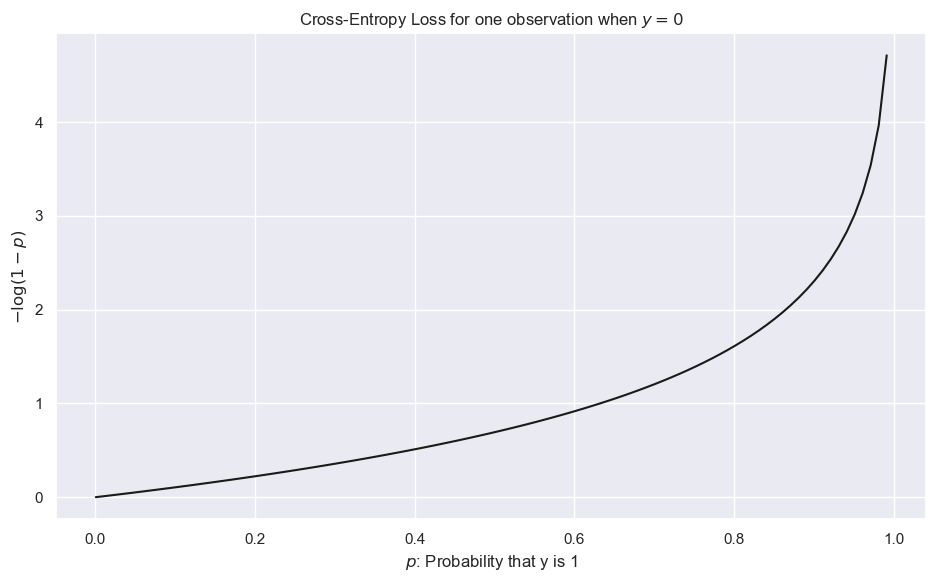

In [74]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(1 - p_hat)
plt.plot(p_hat, loss, color='k')
plt.xlabel('$p$: Probability that y is 1')
plt.ylabel('$-\log(1 - p)$')
plt.title('Cross-Entropy Loss for one observation when $y = 0$');

Much of the formal derivation is in the slides. But the equation for cross-entropy loss for a single observation is

$$\textrm{loss} = -y \log(\hat{y}) - (1-y)\log(1-\hat{y})$$

For us, since $\hat{y} = \sigma(x^T \theta)$, the expression for average cross-entropy loss is

$$R(\theta) = -\frac{1}{n} \sum_{i = 1}^n \big(y_i \log (\sigma(\mathbb{X}_i^T \theta)) + (1 - y_i) \log (1 - \sigma(\mathbb{X}_i^T \theta))\big)$$

Let's look at the loss surface for average cross-entropy loss, on our toy data from before.

In [75]:
def cross_entropy(y, phat):
    return - y * np.log(phat) - (1 - y) * np.log(1 - phat)

In [76]:
def mce_loss_toy_nobias(theta):
    p_hat = sigma(toy_df['x'] * theta)
    return np.mean(cross_entropy(toy_df['y'], p_hat))

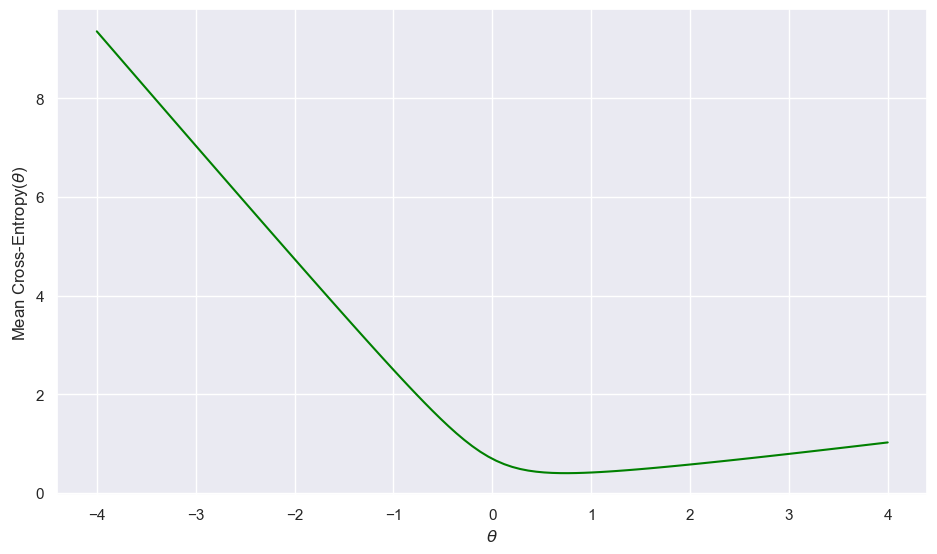

In [77]:
thetas = np.linspace(-4, 4, 100)
plt.plot(thetas, [mce_loss_toy_nobias(theta) for theta in thetas], color = 'green')
plt.ylabel(r'Mean Cross-Entropy($\theta$)')
plt.xlabel(r'$\theta$');

# 10. Logistic Regression using `statsmodels`.

How many hours do you need to study to pass the exam? 

This example was taken from [wikipedia](https://en.wikipedia.org/wiki/Logistic_regression). 

In [78]:
hours = [0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 4.00, 4.25, 4.50, 4.75, 5.00, 5.50] 
pass_Exam = [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
df = pd.DataFrame({"hours": hours, "pass_exam": pass_Exam})
df

,hours,pass_exam
0,0.50,0
1,0.75,0
2,1.00,0
3,1.25,0
4,1.50,0
5,1.75,0
6,1.75,1
7,2.00,0
8,2.25,1
9,2.50,0


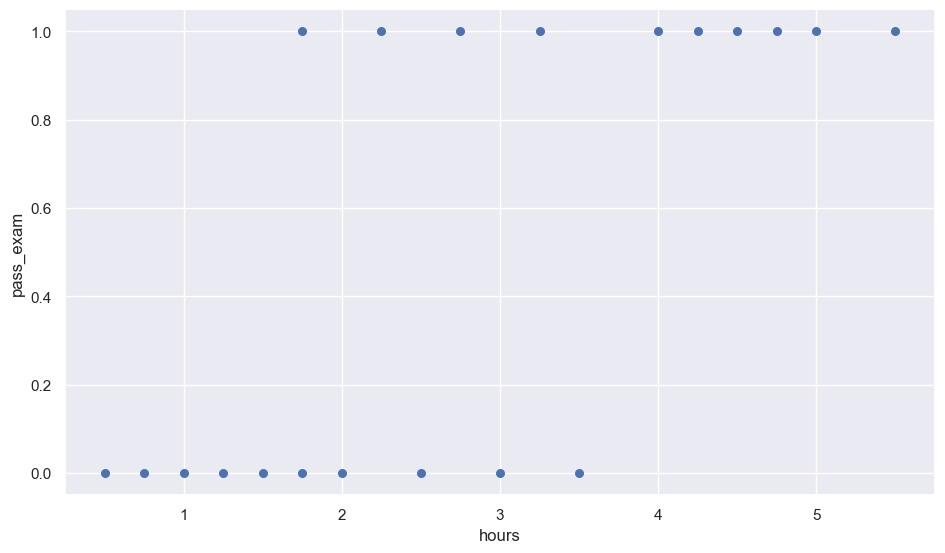

In [79]:
df.plot.scatter(x='hours',y='pass_exam',s=30);

For this example, we want to find coefficients $\theta_0$ and $\theta_1$ so that the model
$$
p(X) = \textrm{probability}(\textrm{passing} | \ \textrm{X hours studying} ) = \textrm{logistic}( \theta_0 + \theta_1 X )
$$
best explains the data. 

We can use the 'logit' function from the statsmodels python library. 

In [80]:
exam_model = sm.logit(formula="pass_Exam ~ hours", data=df).fit()
exam_model.summary()

Optimization terminated successfully.
         Current function value: 0.401494
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              pass_Exam   No. Observations:                   20
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                            1
Date:                Fri, 22 Mar 2024   Pseudo R-squ.:                  0.4208
Time:                        10:05:30   Log-Likelihood:                -8.0299
converged:                       True   LL-Null:                       -13.863
Covariance Type:            nonrobust   LLR p-value:                 0.0006365
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0777      1.761     -2.316      0.021      -7.529      -0.626
hours          1.5046      0.629      2.393      0.017       0.272       2.737
==============================================================================
"""

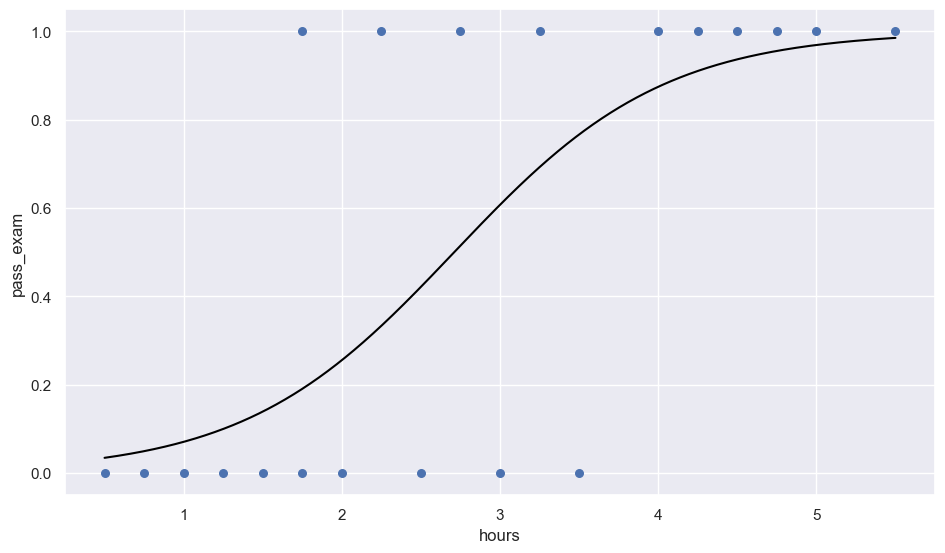

In [81]:
df.plot.scatter(x='hours',y='pass_exam',s=30)
x = np.linspace(df['hours'].min(),df['hours'].max(),1000)
par = dict(exam_model.params)
plt.plot(x,logistic(par['Intercept'] + par['hours']*x),color='Black')
plt.show()

The plot shows hours vs. whether or not the student passed and the logistic regression curve. The curve predicts the probability that a student will pass, given how many hours they've studied. 

From the plot, we can see that the more hours you spend studying, the more likely you are to pass the exam. *Isn't it obvious?* 

If I study just 2 hours, what is the likelihood that I'll pass? 

In [82]:
logistic(par['Intercept'] + par['hours']*2) #just applying the logistic function on the coefficients I estimated

0.25570318264090985

Or I can also get this from `exam_model`:

In [83]:
exam_model.predict(pd.DataFrame({"hours": [2]}))

0    0.255703
dtype: float64

After studying just 2 hours, I'm only $26\%$ likely to pass. 

How many hours do you have to study in order for the probability of passing to be greater than $50\%$?

From the plot, it looks like $\approx 2.75$ hours. How can we find this number from the logistic regression? 

Recall: 
$$
\textrm{logit} ( p(X) ) = \theta_0 + \theta_1 X.  
$$

In [84]:
prob_passing = 0.5
print((logit(prob_passing) - par['Intercept'])/par['hours'])

2.7100826242472498


We can also make a confusion matrix for the model: 

In [85]:
print(exam_model.predict())
df['pred_pass'] = exam_model.predict()>0.5
pd.crosstab(index=df["pass_exam"], columns=df["pred_pass"]) # confusion matrix

[0.03471034 0.04977295 0.07089196 0.10002862 0.13934447 0.1908365
 0.1908365  0.25570318 0.33353024 0.42162653 0.51501086 0.60735865
 0.69261733 0.76648084 0.8744475  0.91027764 0.93662366 0.95561071
 0.96909707 0.98519444]


pred_pass,False,True
pass_exam,,
0,8,2
1,2,8


We interpret this as: for each category (pass,fail), there were two mistakenly classified points. 

**Question**: What is the precision and recall for this model?

\begin{align*}
\textrm{precision} &= \frac{\textrm{TP}}{\textrm{TP} + \textrm{FP}} = \frac{8}{8 + 2} = 80\% \\
\textrm{recall} &= \frac{\textrm{TP}}{\textrm{TP} + \textrm{FN}} =  \frac{8}{8 + 2} = 80\%
\end{align*}